In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Some necessary commands before training.
import os
os.chdir('/content/drive/My Drive/project/notebooks')
!pip install unidecode
!python -m nltk.downloader stopwords

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pwd

/content/drive/My Drive/project/notebooks


# Importing Classes

In [ ]:
from DataPreprocessing import DataPreprocessing
from Summarizer import Summarizer
from Prediction import Prediction

# Data Preprocessing
Before we begin we must get some data and then clean it and make it usable by our model. For that we will be using Datapreprocessing class. We will be using Amazon food reviews dataset.

In [ ]:
processor = DataPreprocessing()
# Read-in dataset
data = processor.load_dataset('Reviews',100000)
print('Dataset Loaded.')

# remove unnnecessary columns
data = processor.remove_columns(data)
print("Unnecessary columns removed.")
data.head(10)

Dataset Loaded.
Unnecessary columns removed.


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
5,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,Yay Barley,Right now I'm mostly just sprouting this so my...
9,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
# clean data
data['Text'], data['Summary'] = processor.clean_data(data)
print('Dataset Cleaned.')

# remove long stories that are longer than 80 and summaries longer than 10
data['Text'], data['Summary'] = processor.remove_long_sequences(data)
print('Long Stories Removed.')

# remove duplicates and na
data = processor.drop_dulp_and_na(data, ['Text', 'Summary'])
print("Duplicates and NaN dropped.")
    
# start and end tokens
data['Summary'] = processor.start_end_token(data['Summary'])
print("Start and End Tokens added.")
data.head(10)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Dataset Cleaned.
Long Stories Removed.
Duplicates and NaN dropped.
Start and End Tokens added.


,Summary,Text
0,sostok good quality dog food eostok,bought several vitality canned dog food produc...
1,sostok not as advertised eostok,product arrived labeled jumbo salted peanuts p...
2,sostok delight says it all eostok,confection around centuries light pillowy citr...
3,sostok cough medicine eostok,looking secret ingredient robitussin believe f...
4,sostok great taffy eostok,great taffy great price wide assortment yummy ...
5,sostok nice taffy eostok,got wild hair taffy ordered five pound bag taf...
6,sostok great just as good as the expensive bra...,saltwater taffy great flavors soft chewy candy...
7,sostok wonderful tasty taffy eostok,taffy good soft chewy flavors amazing would de...
8,sostok yay barley eostok,right mostly sprouting cats eat grass love rot...
9,sostok healthy dog food eostok,healthy dog food good digestion also good smal...


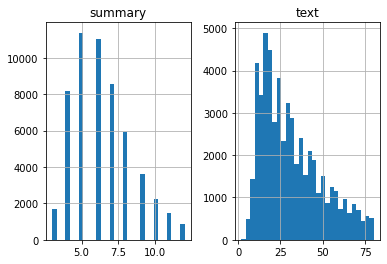

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Text']:
      text_word_count.append(len(i.split()))

for i in data['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

This shows that the ideal summary lenghts are 10 and text lenght are 10. Thus these shoud be kept as max lenght of text and summaries.

Now the textual data has to be coverted into integer seqs. For that we will use keras tokenizer class. For detail implementation see Datapreprosseing.py file.

The tokenized data will be saved in forms of dictionaries and will come in use later.

In [ ]:
#Tokenizer
total_word, rare_word = processor.rare_words_count(data['Text'])
x_seq, x_tokenizer = processor.text2seq(data['Text'], total_word, rare_word)
x_seq = processor.pad_seq(x_seq, processor.max_length_text)

total_word, rare_word = processor.rare_words_count(data['Summary'])
y_seq, y_tokenizer = processor.text2seq(data['Summary'], total_word, rare_word)
y_seq = processor.pad_seq(y_seq, processor.max_length_summary)
print("Tokenization Completed.")

# Tokenizer Data
x_vocab_size, y_vocab_size, input_word_index, target_word_index, reversed_input_word_index, reversed_target_word_index = processor.required_dicts(x_tokenizer,y_tokenizer)
print("Tokenizer Data Loaded.")


Tokenization Completed.
Tokenizer Data Loaded.


In [ ]:
# split data
x_tr, x_test, x_dev, y_tr, y_test, y_dev = processor.split_data(x_seq, y_seq, train_ratio=0.75, dev_ratio=0.125)
print("Data Splitted.")

Data Splitted.


In [ ]:
processor.pickle_data([x_tokenizer, y_tokenizer, x_vocab_size, y_vocab_size, input_word_index, target_word_index, 
reversed_input_word_index, reversed_target_word_index,
processor.max_length_text, processor.max_length_summary], 'TokenizerData')
print("Tokenizer Data Pickled.")

Tokenizer Data Pickled.


# **Model Building**
Now we will build a Seq to Seq model for our summarizer. It will be based upon lstm encoders and decoders. For more details see summarizer.py file.

In [ ]:
# """Model Building""" 
summarizer = Summarizer(input_word_index,target_word_index,x_vocab_size,y_vocab_size)

# Read in glove embeddinsg
embeddings_index = summarizer.read_glove_embeddings()
print("Embedding Vectors Loaded.")

# embedding matrix
embedding_matrix_input, embedding_matrix_target = summarizer.embedding_matrix(embeddings_index)
print("Embedding Matrix Created.")

# Define model
trainer_model, encoder_model, decoder_model = summarizer.define_models(embedding_matrix_input,embedding_matrix_target,
                                                                       processor.max_length_text, processor.max_length_summary)
print("Model Defined.")

# Compile model
summarizer.compile_model(trainer_model)
print("Model Compiled.")

Embedding Vectors Loaded.
Embedding Matrix Created.
Model Defined.
Model Compiled.


In [ ]:
# Train model
history = summarizer.train_model(trainer_model, x_tr, x_dev, y_tr, y_dev,epochs=30,batch_size=64)
print("Model Trained.")

Epoch 1/30
644/644 [==============================] - 596s 925ms/step - loss: 3.2053 - val_loss: 2.8906
Epoch 2/30
644/644 [==============================] - 596s 925ms/step - loss: 2.7725 - val_loss: 2.6658
Epoch 3/30
644/644 [==============================] - 581s 903ms/step - loss: 2.5767 - val_loss: 2.5254
Epoch 4/30
644/644 [==============================] - 583s 905ms/step - loss: 2.4242 - val_loss: 2.4410
Epoch 5/30
644/644 [==============================] - 586s 909ms/step - loss: 2.3017 - val_loss: 2.3902
Epoch 6/30
644/644 [==============================] - 588s 913ms/step - loss: 2.1997 - val_loss: 2.3537
Epoch 7/30
644/644 [==============================] - 584s 907ms/step - loss: 2.1123 - val_loss: 2.3391
Epoch 8/30
644/644 [==============================] - 580s 901ms/step - loss: 2.0374 - val_loss: 2.3323
Epoch 9/30
644/644 [==============================] - 583s 905ms/step - loss: 1.9705 - val_loss: 2.3317
Epoch 10/30
644/644 [==============================] - 588s 912m

Diagnostic Plot: 


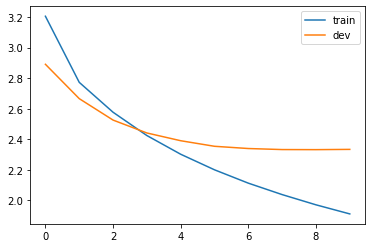

In [ ]:
# Disgnostic plot
print("Diagnostic Plot: ")
summarizer.diagnostic_plot(history)

In [ ]:
# Save model
summarizer.save_model(encoder_model, decoder_model)
print("Model Saved.")

Model Saved.


# Predictions

In [ ]:
"""Predictions"""
from Prediction import Prediction
loaded_data = processor.load_pickle('TokenizerData')
predictor = Prediction(loaded_data)

# Load trained model
encoder_model = predictor.load_model('encoder_model.json', 'encoder_model_weights.h5')
decoder_model = predictor.load_model('decoder_model.json', 'decoder_model_weights.h5')
print("Model Loaded.")

# Generate summaries
for i in range(10,30):
    print("Original Text: ",predictor.seqtotext(x_test[i]))
    print("Original: ",predictor.seqtosummary(y_test[i]))
    print("Predicted: " ,predictor.decode_sequence(x_test[i].reshape(1,80), encoder_model, decoder_model))
    print("\n")

Model Loaded.
Original Text:  plants looked dead small watered directed still look weeks follow directions every time water 
Original:  air plants 
Predicted:  pitcher plant 


Original Text:  feel lucked treat health properties sweetened honey adds rich soothing flavor good hot cold others noted gentle upset stomach indigestion good home remedy 
Original:  good home remedy 
Predicted:  great for cramps 


Original Text:  regret buying gift basket picture shows price bought chocolate set rather 
Original:  gift basket sucks 
Predicted:  great deal for chocolate 


Original Text:  tastes good guy doesnt cook often bored type food everytime oil floating noticed cooking particular diet may avoid 
Original:  it tastes good as it is supposed to 
Predicted:  tastes like fish 


Original Text:  tour operator always looking high quality reasonably priced snacks offer customers trips snyder brand appreciate able purchase bulk quantities pretzels great low price 
Original:  snyder of hanover pre

# Conclusion
The model is producing mixed summaries. Some are very good, some are bad. This was a basic model and was trained for only 10 epochs. It can be futher imporved by adding more lstm layers in model and also by taining it more than 10 epochs.

